In [1]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.9 MB/s eta 0:00:00


In [2]:
!pip install statannot

In [3]:
#Basic packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Descriptive statistics:
from scipy.stats import shapiro

#Classification model:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier #k-nn
from sklearn.linear_model import LinearRegression #simple linear regression
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.metrics import *

#Longitudinal model:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

In [18]:
#Import dataset LARN>SummerSchool>dataset_CB23.csv
df = pd.read_csv('/content/dataset_CB23.csv')
print(df)

      patient_id sex  age_years  years_education visit  APOE4 apoe_result  \
0              1   f         51               11    V1    0.0       e3/e3   
1              2   m         76               10    V1    2.0       e4/e4   
2              3   f         61               14    V1    0.0       e3/e3   
3              4   f         53               10    V1    1.0       e2/e4   
4              5   f         77               20    V1    1.0       e3/e4   
...          ...  ..        ...              ...   ...    ...         ...   
2995         996   m         93               12    V3    NaN         NaN   
2996         997   m         86               13    V3    1.0       e3/e4   
2997         998   m         66               20    V3    1.0       e3/e4   
2998         999   m         76               16    V3    1.0       e3/e4   
2999        1000  un         63               14    V3    2.0       e4/e4   

     family_dementia_history  ptau_result  ttau_result  ...  Depression  \


In [ ]:
df.dtypes

patient_id                   int64
sex                         object
age_years                    int64
years_education              int64
visit                       object
APOE4                      float64
apoe_result                 object
family_dementia_history     object
ptau_result                float64
ttau_result                float64
abeta42_result             float64
AMYL                       float64
TAUO                       float64
NEUROD                     float64
ATN                         object
MONTHS                     float64
mmse_total                 float64
np_date                     object
gds_total                  float64
Depression                 float64
cdr_global                 float64
DX                          object
cdr_sob                    float64
LHVL                       float64
LHVR                       float64
LHV                        float64
LWMV                       float64
VASCULAR                   float64
DXCHANGE            

In [ ]:
for col in df.columns:
    print(col)

patient_id
sex
age_years
years_education
visit
APOE4
apoe_result
family_dementia_history
ptau_result
ttau_result
abeta42_result
AMYL
TAUO
NEUROD
ATN
MONTHS
mmse_total
np_date
gds_total
Depression
cdr_global
DX
cdr_sob
LHVL
LHVR
LHV
LWMV
VASCULAR
DXCHANGE


In [19]:
#Select the patients at baseline.
df_bl = df.loc[0:1000]
print(df_bl)

      patient_id sex  age_years  years_education visit  APOE4 apoe_result  \
0              1   f         51               11    V1    0.0       e3/e3   
1              2   m         76               10    V1    2.0       e4/e4   
2              3   f         61               14    V1    0.0       e3/e3   
3              4   f         53               10    V1    1.0       e2/e4   
4              5   f         77               20    V1    1.0       e3/e4   
...          ...  ..        ...              ...   ...    ...         ...   
996          997   m         81               13    V1    1.0       e3/e4   
997          998   m         66               20    V1    1.0       e3/e4   
998          999   m         70               16    V1    1.0       e3/e4   
999         1000  un         57               14    V1    2.0       e4/e4   
1000           1   f         52               11    V2    0.0       e3/e3   

     family_dementia_history  ptau_result  ttau_result  ...  Depression  \


In [ ]:
#Descriptive statistics:
df_bl.groupby('DX')['age_years'].describe()

,count,mean,std,min,25%,50%,75%,max
DX,,,,,,,,
Dem,544.0,68.926471,11.601189,50.0,59.0,69.0,79.00,90.0
MCI,204.0,70.357843,12.434038,50.0,60.0,70.0,81.25,90.0
NC,158.0,70.398734,11.973931,50.0,60.0,71.0,80.75,90.0


In [ ]:
stat, p = shapiro(df_bl['age_years'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000
Sample does not look Gaussian (reject H0)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NC v.s. MCI: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.203e-236 stat=1.080e+03
MCI v.s. Dem: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.568e-288 stat=1.317e+03
NC v.s. Dem: Kruskal-Wallis paired samples with Bonferroni correction, P_val=9.443e-280 stat=1.280e+03


(<Axes: xlabel='DX', ylabel='cdr_global'>,
  <statannot.StatResult.StatResult at 0x7b56051b2080>])

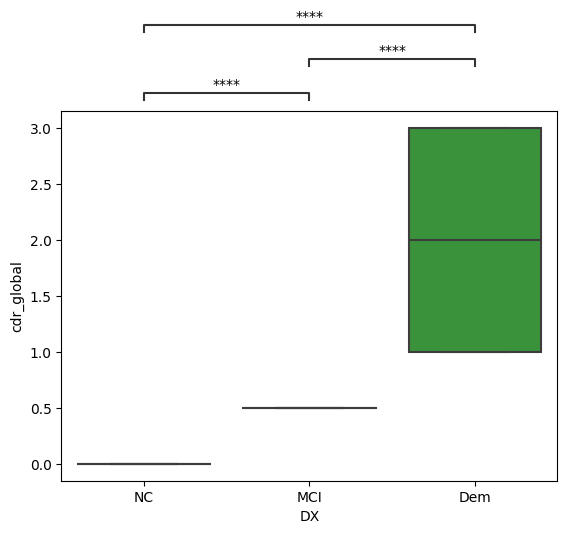

In [21]:
from statannot import add_stat_annotation

x = "DX"
y = "cdr_global"
order = ['NC', 'MCI', 'Dem']
ax = sns.boxplot(data=df_bl, x=x, y=y, order=order)
add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                    box_pairs=[("NC", "MCI"), ("NC", "Dem"), ("MCI", "Dem")],
                    test='Kruskal', text_format='star', loc='outside', verbose=2)

In [ ]:
df_bl.dropna(subset=['DX'], inplace=True)

<ipython-input-72-0c4090d0f695>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bl.dropna(subset=['DX'], inplace=True)


In [22]:
#Classification models:
df_cl = pd.read_csv('/content/dataset_CB23_Clas.csv')
Y = df_cl['DX']
X = df_cl.drop(['DX'], axis=1)

X.head()


,patient_id,sex,age_years,years_education,visit,APOE4,apoe_result,family_dementia_history,ptau_result,ttau_result,...,mmse_total,gds_total,Depression,cdr_global,cdr_sob,LHVL,LHVR,LHV,LWMV,VASCULAR
0,1,2,51,11,0,0,33,1,16.3,331,...,16,9,0,2.0,16.5,-1.701,-0.521,-2.221,-0.723,0
1,2,1,76,10,0,2,44,1,22.9,223,...,14,14,1,0.5,1.5,0.254,0.025,0.279,0.000,1
2,3,2,61,14,0,0,33,1,19.8,202,...,15,-7,-7,1.0,5.5,-0.642,-0.657,-1.299,0.210,1
3,5,2,77,20,0,1,34,1,-7.0,-7,...,12,16,1,2.0,5.5,0.095,-1.189,-1.094,-0.567,0
4,6,1,56,19,0,2,44,1,8.0,170,...,20,14,1,1.0,10.5,-0.909,-0.139,-1.048,-0.827,0


In [23]:
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
print("kNN model accuracy:", metrics.accuracy_score(Y_test, Y_pred))
results = confusion_matrix(Y_test, Y_pred)
print ('Confusion Matrix :')
print(results)
print ('Classification Report : ')
print (classification_report(Y_test, Y_pred))

kNN model accuracy: 0.44751381215469616
Confusion Matrix :
[[ 12   5  41]
 [ 20   8  53]
 [ 53  28 142]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.14      0.21      0.17        58
           1       0.20      0.10      0.13        81
           2       0.60      0.64      0.62       223

    accuracy                           0.45       362
   macro avg       0.31      0.31      0.31       362
weighted avg       0.44      0.45      0.44       362



In [24]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(X_train, Y_train)
Y_pred_rf = rf.predict(X_test)
print("RF model accuracy:", metrics.accuracy_score(Y_test, Y_pred_rf))
results_rf = confusion_matrix(Y_test, Y_pred_rf)
print ('Confusion Matrix :')
print(results_rf)
print ('Classification Report : ')
print (classification_report(Y_test, Y_pred_rf))

RF model accuracy: 1.0
Confusion Matrix :
[[ 58   0   0]
 [  0  81   0]
 [  0   0 223]]
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00       223

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362



In [ ]:
!pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=1cabe1286d9e18c9279ae0a8c3dfbb127ccb4df456717b4327ed6272c37e3918
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=f855434995c1165028809cb4c7d862a255e956361c250adf0217017e4e496374
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap

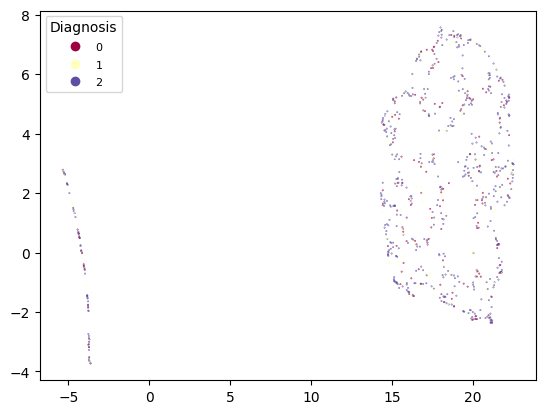

In [ ]:
clusterable_embedding = umap.UMAP(
    #n_neighbors = 100,
    n_components=2,
    random_state=0,
).fit_transform(df_cl)
plot1 = plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=df_cl.DX, s=0.1, cmap='Spectral')
plt.legend(*plot1.legend_elements(),
           title="Diagnosis", fontsize=8)

Silhouetter Score: 0.3373


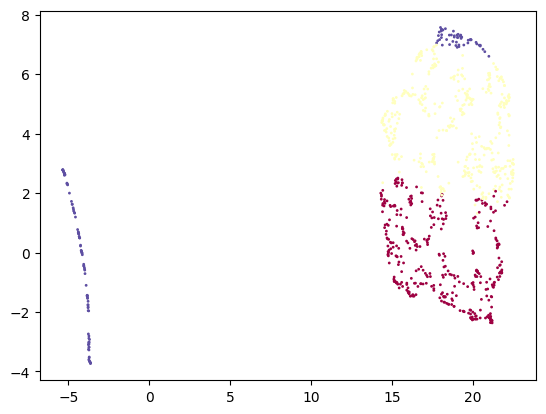

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_labels= km.fit_predict(df_cl)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=kmeans_labels, s=1, cmap='Spectral');
score = silhouette_score(df_cl, km.labels_, metric='euclidean')
print('Silhouetter Score: %.4f' % score)

In [4]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ee99cbc5297002eaf09cf6527f3ddb9d7bd54e143566317097fbc08596dd5f9e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [5]:
#Longitudinal models:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import KaplanMeierFitter


In [6]:
df_time = pd.read_csv('/content/dataset_CB23_Long.csv')
print(df_time)

     patient_id   DX  sex  age_years  years_education  APOE4  \
0             1  Dem    2         51               11    0.0   
1             2  MCI    1         76               10    2.0   
2             3  Dem    2         61               14    0.0   
3             5  Dem    2         77               20    1.0   
4             6  Dem    1         56               19    2.0   
..          ...  ...  ...        ...              ...    ...   
900         996  MCI    1         89               12    NaN   
901         997  Dem    1         81               13    1.0   
902         998  MCI    1         66               20    1.0   
903         999  Dem    1         70               16    1.0   
904        1000  MCI    0         57               14    2.0   

     family_dementia_history  AMYL  TAUO  NEUROD  MONTHS  STATUS  mmse_total  \
0                          1   0.0   0.0     1.0    53.0     0.0        16.0   
1                          1   0.0   0.0     0.0    44.0     0.0       

In [7]:
df_time = df_time[df_time['MONTHS'].notna()]
df_time = df_time[df_time['STATUS'].notna()]

In [8]:
print(df_time)

     patient_id   DX  sex  age_years  years_education  APOE4  \
0             1  Dem    2         51               11    0.0   
1             2  MCI    1         76               10    2.0   
3             5  Dem    2         77               20    1.0   
4             6  Dem    1         56               19    2.0   
5             7  MCI    2         80               19    2.0   
..          ...  ...  ...        ...              ...    ...   
898         994  Dem    2         73               18    0.0   
899         995   NC    0         60               14    NaN   
901         997  Dem    1         81               13    1.0   
903         999  Dem    1         70               16    1.0   
904        1000  MCI    0         57               14    2.0   

     family_dementia_history  AMYL  TAUO  NEUROD  MONTHS  STATUS  mmse_total  \
0                          1   0.0   0.0     1.0    53.0     0.0        16.0   
1                          1   0.0   0.0     0.0    44.0     0.0       

In [ ]:
df_time.dtypes

patient_id                   int64
DX                          object
sex                          int64
age_years                    int64
years_education              int64
APOE4                      float64
family_dementia_history      int64
AMYL                       float64
TAUO                       float64
NEUROD                     float64
MONTHS                     float64
STATUS                      object
mmse_total                 float64
gds_total                  float64
cdr_sum_of_box             float64
dtype: object

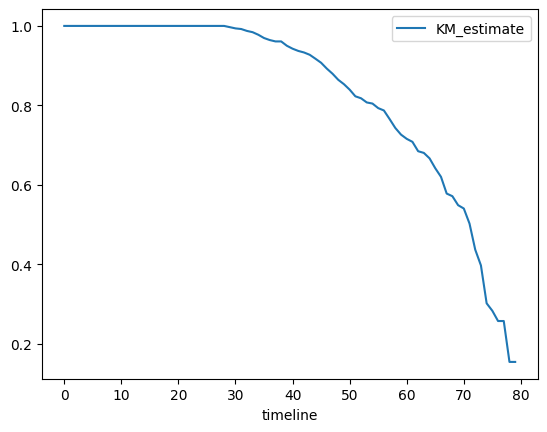

In [10]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df_time['MONTHS'], event_observed = df_time['STATUS'])
kmf.survival_function_.plot()
plt.show()

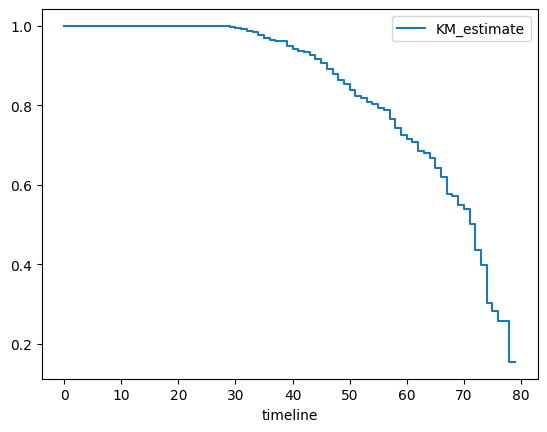

In [ ]:
kmf.plot(ci_show = False)
plt.show()

In [17]:
print(kmf.survival_function_)

          KM_estimate
timeline             
0.0          1.000000
25.0         1.000000
26.0         1.000000
27.0         1.000000
28.0         1.000000
29.0         0.996904
30.0         0.993769
31.0         0.992194
32.0         0.987439
33.0         0.984218
34.0         0.977742
35.0         0.969526
36.0         0.964441
37.0         0.960991
38.0         0.960991
39.0         0.950070
40.0         0.942691
41.0         0.937069
42.0         0.933204
43.0         0.927372
44.0         0.917485
45.0         0.907245
46.0         0.892545
47.0         0.879672
48.0         0.864430
49.0         0.853347
50.0         0.839620
51.0         0.822876
52.0         0.817858
53.0         0.807407
54.0         0.804593
55.0         0.793181
56.0         0.787194
57.0         0.765585
58.0         0.743162
59.0         0.726424
60.0         0.715794
61.0         0.708259
62.0         0.684650
63.0         0.680398
64.0         0.666699
65.0         0.641822
66.0         0.620248
67.0      

In [16]:
kmf.predict(30) #Probability of not progressing after 30 months.

0.9937691064509219

In [ ]:
controls = (df_time['DX'] == 'NC')
prodromal = (df_time['DX'] == 'MCI')
dementia = (df_time['DX'] == 'Dem')

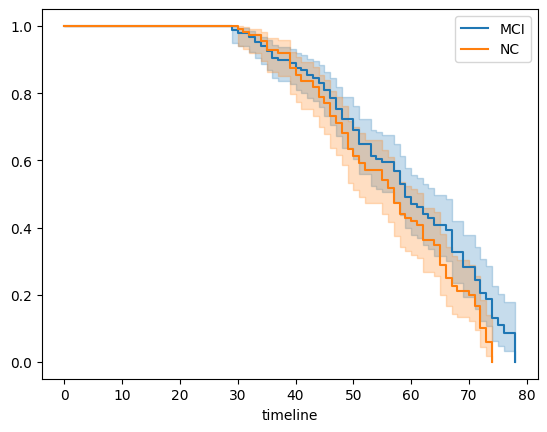

In [ ]:
ax= plt.subplot(111)
kmf.fit(durations = df_time[prodromal]['MONTHS'], event_observed = df_time[prodromal]['STATUS'], label = "MCI")
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = df_time[controls]['MONTHS'], event_observed = df_time[controls]['STATUS'], label = "NC")
kmf.plot_survival_function(ax=ax)
plt.show()